<a href="https://colab.research.google.com/github/hws2002/Deep_Learning_with_Keras/blob/main/Chapter4/Chapter4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주택 가격 예측 : 회귀 문제
1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값을 예측해 보자.  
여기에서 사용할 데이터셋은 데이터 포인트가 506개로 비교적 개수가 적고, 404개는 훈련 샘플로, 102개는 테스트 샘플로 나뉘어져 있음.  

입력 데이터에 있는 각 특성은 스케일이 서로 다름. 어떤 값은 0과 1사이의 비율을 나타내고, 어떤 것은 1과 12 사이의 값을 가지거나 1과 100사이의 값을 가짐.  


In [1]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

# 데이터 준비

In [6]:
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std
test_data -= mean
test_data /= std

# 모델 구성

In [7]:
import keras
from keras import layers
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation = "relu"),
      layers.Dense(64, activation = "relu"),
      layers.Dense(1)
  ])
  model.compile(
      optimizer = "rmsprop",
      loss = 'mse',
      metrics = ['mae']
  )
  return model

이 모델의 마지막 층은 하나의 유닛을 가지고 있고 활성화 함수가 없음(선형 층이라고 부름)  
이것이 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성임.  
활성화 함수를 적용하면 출력 값의 범위를 제한하게 됨.  
여기에서는 마지막 층이 순수한 선형이므로 모델이 어떤 범위의 값이라도 예측하도록 자유롭게 학습됨.

# k-겹 검증을 사용한 훈련 검증

In [8]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print(f"#{i}번째 폴드 처리중")
  val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
  partial_train_data = np.concatenate(
      [train_data[: i * num_val_samples],
      train_data[(i+1) * num_val_samples : ]],
      axis = 0
  )

  partial_train_targets = np.concatenate(
      [train_targets[ : i * num_val_samples],
       train_targets[(i+1) * num_val_samples : ]],
      axis = 0
  )

  model = build_model()
  model.fit(
      partial_train_data,
      partial_train_targets,
      epochs = num_epochs,
      batch_size = 16,
      verbose = 0
  )
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0) # loss, metrics
  all_scores.append(val_mae)


#0번째 폴드 처리중
#1번째 폴드 처리중
#2번째 폴드 처리중
#3번째 폴드 처리중


In [9]:
all_scores

[2.0069327354431152, 2.2403225898742676, 2.498262405395508, 2.4166996479034424]

In [10]:
np.mean(all_scores)

2.2905543446540833

평균적으로 2290달러 정도 차이가 남.  
주택 가격의 범위가 1만 달러에서 5만 달러 사이인 것을 감안하면 비교적 큰 값임.  

이 모델을 조금 더 오래 500 에포크 동안 훈련해 보자.  
각 에포크마다 모델이 얼마나 개선되는지 기록하기 위해 훈련 루프를 조금 수정해서 에포크마다 각 폴드의 검증 점수를 로그에 저장해보자.  

In [15]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print(f"#{i}번째 폴드 처리중")
  val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
  partial_train_data = np.concatenate(
      [train_data[: i * num_val_samples],
      train_data[(i+1) * num_val_samples : ]],
      axis = 0
  )

  partial_train_targets = np.concatenate(
      [train_targets[ : i * num_val_samples],
       train_targets[(i+1) * num_val_samples : ]],
      axis = 0
  )

  model = build_model()
  history = model.fit(
      partial_train_data,
      partial_train_targets,
      epochs = num_epochs,
      batch_size = 16,
      verbose = 0,
      validation_data = (val_data, val_targets)
  )

  mae_history = history.history['val_mae'] # 500개의 validation_loss
  all_mae_histories.append(mae_history)

#0번째 폴드 처리중
#1번째 폴드 처리중
#2번째 폴드 처리중
#3번째 폴드 처리중


In [17]:
len(all_mae_histories)

4

In [21]:
average_mean_history = [
    np.mean([x[i] for x in all_mae_histories])for i in range(num_epochs)
] # 500개의 mae가 나올것

In [22]:
len(average_mean_history)

500

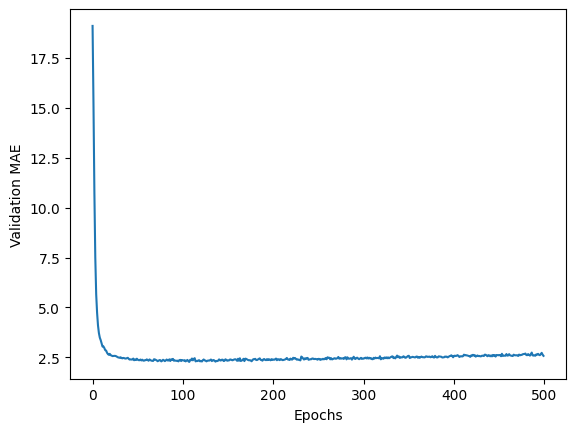

In [24]:
import matplotlib.pyplot as plt
plt.plot(average_mean_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

이 그래프는 범위가 크기 떄문에 보기가 좀 어려움.  
처음 몇 번의 에포크 동안 MAE가 그 이후 에포크보다 너무 높음.  
나머지 곡선 부분과 스케일이 크게 다른 처음 10개의 데이터 포인트를 제외시켜 보자.

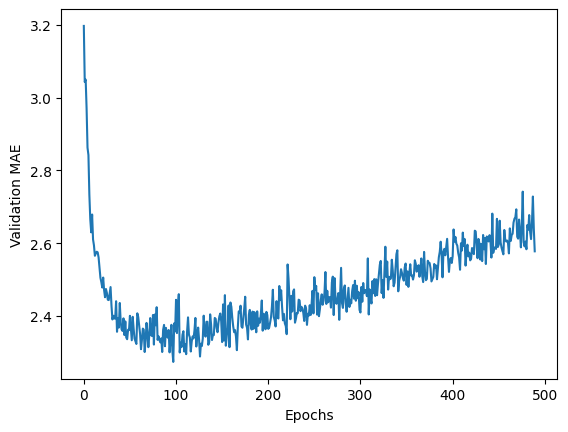

In [25]:
truncated_mae_history = average_mean_history[10:]
plt.plot(truncated_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

검증 MAE가 120~140번째 에포크 이후에 줄어드는 것이 멈추었음.  
즉, 이 지점 이후로는 과대적합이 시작된다고 볼 수 있음.  


모델의 여러 매개변수에 대한 튜닝이 끝나면(에포크의 수뿐만 아니라 중간층의 크기도 조절할 수 있음) 모든 훈련 데이터를 사용하고 최상의 매개변수로 최종 실전에 투입될 모델을 훈련시킨다. 그 후 테스트 데이터로 성능을 확인한다.

In [26]:
model = build_model()
model.fit(train_data, train_targets,
          epochs = 130,
          batch_size = 16, verbose = 1)
test_mse_los, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 467.6016 - mae: 19.7396   
Epoch 2/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 264.9527 - mae: 14.1716 
Epoch 3/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104.6969 - mae: 7.8412 
Epoch 4/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40.6381 - mae: 4.8446 
Epoch 5/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.9766 - mae: 3.8255 
Epoch 6/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.3108 - mae: 3.3124 
Epoch 7/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.6523 - mae: 3.2961 
Epoch 8/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.0740 - mae: 3.1254
Epoch 9/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.9141 - mae: 2.8276 
Epoch 10/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.9980 - mae: 2.4492 
Epoch 11/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.9714 - mae: 2.6053 
Epoch 12/130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.5799 - mae: 2.6143
Epoch 13

In [27]:
test_mae_score

2.5436363220214844

최종 결과를 보면 아직도 2,500달러 정도 차이가 남을 알 수 있다.  
그럼 이제 모델 층 수나 층의 유닛 개수를 바꾸어 테스트 오차를 더 낮출 수 있는지 확인해 볼 수 있다.  

# 새로운 데이터에 대해 예측하기


In [28]:
predictions = model.predict(test_data)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([9.333217], dtype=float32)

테스트 세트에 있는 첫 번째 주택의 가격은 약 1만 달러로 예상됨.